# Twitter 10k

Following my 10.000th tweet, I downloaded my [Twitter archive](https://help.twitter.com/en/managing-your-account/how-to-download-your-twitter-archive) and created this notebook where I analyzed and visualized 9 years of sharing my thoughts on Twitter.

<img align="float:left" src=https://i.imgur.com/O8pgmNC.png/>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read the tweets.csv file into a datframe
df = pd.read_csv('tweets.csv')
print('Shape: ', df.shape)
df.head()

Shape:  (9985, 10)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls
0,1032699014154805248,NaN,NaN,2018-08-23 18:40:06 +0000,"<a href=""http://twitter.com/download/android"" ...",Wow a reply from the master himself. This one ...,NaN,NaN,NaN,https://twitter.com/Axwell/status/103269838404...
1,1032696476751880194,1.032689e+18,20940081.0,2018-08-23 18:30:01 +0000,"<a href=""http://twitter.com/download/android"" ...",@Axwell What do you use for your hair (serious...,NaN,NaN,NaN,NaN
2,1032682250368892928,NaN,NaN,2018-08-23 17:33:29 +0000,"<a href=""http://twitter.com/download/android"" ...",This one right here is my 10000th (in words: t...,NaN,NaN,NaN,NaN
3,1032680653161222145,1.032676e+18,80422885.0,2018-08-23 17:27:08 +0000,"<a href=""http://twitter.com/download/android"" ...",@kaggle Is it possible to find out where those...,NaN,NaN,NaN,NaN
4,1032643301604843522,NaN,NaN,2018-08-23 14:58:43 +0000,"<a href=""https://mobile.twitter.com"" rel=""nofo...","RT @vboykis: Name a more iconic trio, I'll wai...",1.032631e+18,19304217.0,2018-08-23 14:10:24 +0000,https://twitter.com/vboykis/status/10326311450...


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9985 entries, 0 to 9984
Data columns (total 10 columns):
tweet_id                      9985 non-null int64
in_reply_to_status_id         2876 non-null float64
in_reply_to_user_id           2980 non-null float64
timestamp                     9985 non-null object
source                        9985 non-null object
text                          9985 non-null object
retweeted_status_id           738 non-null float64
retweeted_status_user_id      738 non-null float64
retweeted_status_timestamp    738 non-null object
expanded_urls                 2032 non-null object
dtypes: float64(4), int64(1), object(5)
memory usage: 780.2+ KB


# data cleaning/ wrangling

In [3]:
# get list of all float type columns
# basically all columns which are some variation of in_reply_to_x or retweeted_status/user_id
float_cols = list(df.select_dtypes(include=['float']).columns.values)
print(float_cols)

['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id']


In [4]:
# fill Nan's for all float types
df[float_cols] = df[float_cols].fillna(0)

# convert float_cols to int
df[float_cols] = df[float_cols].astype(int)

# convert timestamp column to datetime type
df['timestamp'] = pd.to_datetime(df['timestamp'])

What is the difference between columns in_reply_to_status_id and in_reply_to_user_id?

In [5]:
# check tweets which have NaN for in_reply_to_status_id but not for in_reply_to_user_id
df[(df['in_reply_to_status_id'] == 0) & (df['in_reply_to_user_id'] != 0)].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls
31,1028165302432002049,0,39999078,2018-08-11 06:24:45,"<a href=""http://twitter.com/download/android"" ...","@DB_Bahn guten Morgen, gilt die Aufhebung der ...",0,0,NaN,NaN
175,1005404002668961792,0,10700052,2018-06-09 10:59:28,"<a href=""http://twitter.com/download/android"" ...","@raduceuca hi Radu, thank you for the amazing ...",0,0,NaN,https://twitter.com/tgel0/status/1005404002668...
204,1002167897467351040,0,14698049,2018-05-31 12:40:20,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","@alexip hi Alexis, I'm using Python on GCP aft...",0,0,NaN,https://www.datacamp.com/community/tutorials/g...
374,978620471569772545,0,16695590,2018-03-27 13:11:16,"<a href=""http://twitter.com/download/android"" ...","@vodafone_de hallo, habe seit 1 Std. kein Kabe...",0,0,NaN,NaN
419,975683429462368256,0,4212105472,2018-03-19 10:40:31,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@novoresume quick q: what happens with my resu...,0,0,NaN,NaN


The above selected tweets are not actual replies but rather first/initial messages to a particular user on Twitter.

It seems therefore that status_id is basically an id of a tweet hence why it is missing in the above examples (as it's the first message and not an actual reply).

I will save those first/initial messages as a separate column and call them 'mentions'.

In [6]:
# save as new column
df['mention_to_user_id'] = df['in_reply_to_user_id'][(df['in_reply_to_status_id'] == 0)
                                                     & (df['in_reply_to_user_id'] != 0)]
# fill Nan's here as well
df['mention_to_user_id'] = df['mention_to_user_id'].fillna(0)

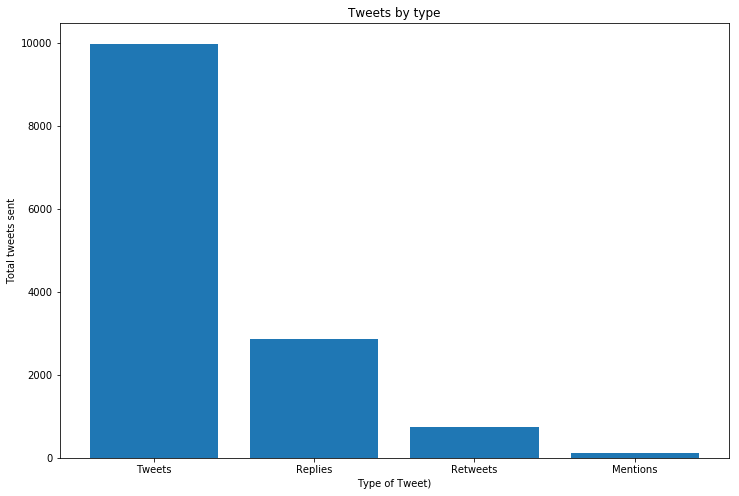

In [7]:
# create dictionary with values to plot
# the imputed zeros need to be excluded here
data = {
        'Tweets': (df['tweet_id'] != 0).sum(),
        'Replies': (df['in_reply_to_status_id']!=0).sum(), 
        'Retweets': (df['retweeted_status_id'] != 0).sum(),
        'Mentions':  (df['mention_to_user_id'] != 0).sum()
        }

names = list(data.keys())
values = list(data.values())

# plot the above data
# set the figure size
plt.figure(figsize=(12,8))

# create a countplot, ordered by count
plt.bar(names, values)

# set the labels and title
plt.xlabel('Type of Tweet)')
plt.ylabel('Total tweets sent')
plt.title('Tweets by type');

The source colum consists of an HTML tag which includes the name of the Twitter client used to send out the particular tweet.

I will extract the actual source name using *the power of regular expressions.*

In [8]:
df['source'].head()

0    <a href="http://twitter.com/download/android" ...
1    <a href="http://twitter.com/download/android" ...
2    <a href="http://twitter.com/download/android" ...
3    <a href="http://twitter.com/download/android" ...
4    <a href="https://mobile.twitter.com" rel="nofo...
Name: source, dtype: object

In [9]:
# first extracting the client name including the >< characters
for source in df['source']:
    df['source'] = df['source'].str.extract('(\>.*\<)', expand=False) #output example: '>Twitter for Android<'
    
# after that extracting only the letters
for source in df['source']:
    df['source'] = df['source'].str.extract('([a-zA-Z ]+)', expand=False) #output example: 'Twitter for Android'

In [10]:
# get the value counts for source column
df['source'].value_counts()

Twitter for Android        2468
twicca                     1692
Twitter Web Client         1457
Fenix for Android          1348
TweetCaster                 453
Carbon for Android          379
TweetDeck                   343
Echofon                     269
Echofon  Android            253
Twidere for Android         249
Fenix                       243
 Tweedle                    195
Foursquare                  129
Buffer                      118
Instagram                    63
Twitter for iPad             60
Twitter for Websites         52
Twitter Lite                 47
Hootsuite                    44
Twitterrific for iOS         26
Plume                        24
TweetCaster for Android      23
erased                       20
Slices for Android           12
Pocket                        7
iOS                           4
Yfrog                         2
Silver Bird                   1
FMH                           1
TweetPhoto                    1
Periscope                     1
Twitlong

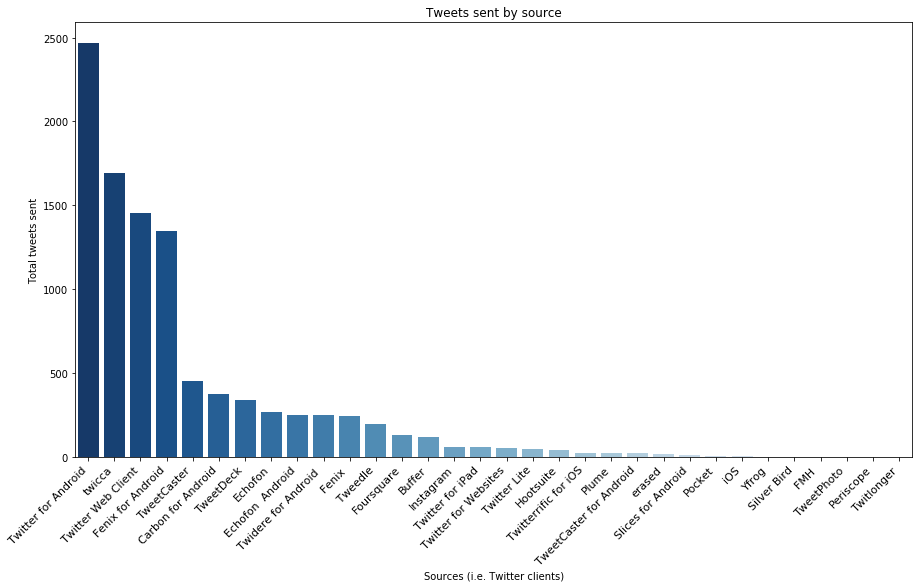

In [11]:
# plot the above data
# set the figure size
plt.figure(figsize=(15,8))

# create a countplot, ordered by count
sns.countplot(x='source', data=df, palette = 'Blues_r' , order = df['source'].value_counts().index)

# rotate the ticks for better readability
plt.xticks(rotation=45, fontsize='11', horizontalalignment='right')

# set the labels and title
plt.xlabel('Sources (i.e. Twitter clients)')
plt.ylabel('Total tweets sent')
plt.title('Tweets sent by source');

As you can see, I tried a lot of different clients over the years but the default Twitter app is still by far the most used one.

To do some more fancy stuff with the source information I need to transform this column into dummy columns.

Since this will create 30+ new columns I will also merge the lesser used ones into one single column.

In [12]:
# convert source column into dummy columns
df = pd.get_dummies(data=df, columns=['source'], drop_first=True)

# get list of all newly created source columns
source_cols = list(df.columns[df.columns.str.startswith('source')])

# use that list to create a new list with all source columns ordered by sum
source_cols_ordered = list(df[source_cols].sum().sort_values(ascending=False).index)

# use that list to create a list with the 16 least used sources 
other_source = source_cols_ordered[-16:]

# merge lesser used source columns into one single column
df['source_Other'] = df[other_source].sum(1)

# drop 'old' columns
df = df.drop(other_source, 1)
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,mention_to_user_id,...,source_Foursquare,source_Instagram,source_TweetCaster,source_TweetDeck,source_Twidere for Android,source_Twitter Web Client,source_Twitter for Android,source_Twitter for iPad,source_twicca,source_Other
0,1032699014154805248,0,0,2018-08-23 18:40:06,Wow a reply from the master himself. This one ...,0,0,NaN,https://twitter.com/Axwell/status/103269838404...,0.0,...,0,0,0,0,0,0,1,0,0,0
1,1032696476751880194,1032689490748428288,20940081,2018-08-23 18:30:01,@Axwell What do you use for your hair (serious...,0,0,NaN,NaN,0.0,...,0,0,0,0,0,0,1,0,0,0
2,1032682250368892928,0,0,2018-08-23 17:33:29,This one right here is my 10000th (in words: t...,0,0,NaN,NaN,0.0,...,0,0,0,0,0,0,1,0,0,0
3,1032680653161222145,1032676389311467520,80422885,2018-08-23 17:27:08,@kaggle Is it possible to find out where those...,0,0,NaN,NaN,0.0,...,0,0,0,0,0,0,1,0,0,0
4,1032643301604843522,0,0,2018-08-23 14:58:43,"RT @vboykis: Name a more iconic trio, I'll wai...",1032631145035427840,19304217,2018-08-23 14:10:24 +0000,https://twitter.com/vboykis/status/10326311450...,0.0,...,0,0,0,0,0,0,0,0,0,1


# text data analysis

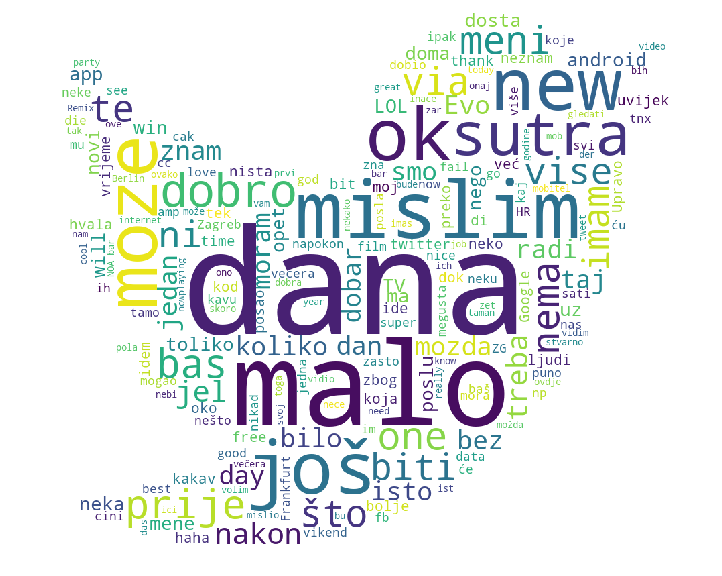

In [13]:
from wordcloud import WordCloud, STOPWORDS
import imageio

# join tweets to a single string
words = ' '.join(df['text'])

# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

# create a twitter-style mask for the wordcloud
twitter_mask = imageio.imread('twitter_mask.png')

# add some Croatian stopwords manually
cro_stopwords = {
                'si','se','su','sa','ce','cu','za','je','ja','ti','mi','da','od','kad','sam','pa','po','ili','ali','li',
                'ako','iz','ne','nije','nisam','sad','sto','samo','ovo','ovaj','na','ima','ko','ova','koji','neki',
                'jos','jo','jer','bi','ba','kako','sve','tako', 'ga','tu','bio','onda','kao','vec', 'nesto','mogu'    
                }
STOPWORDS = STOPWORDS.union(cro_stopwords)

# generate the wordcloud
wordcloud = WordCloud(
                    stopwords = STOPWORDS,
                    background_color='white',
                    width=1800, 
                    height=1400, 
                    mask=twitter_mask
                    ).generate(no_urls_no_tags)

# set the figure size
plt.figure(figsize=(12,12))

# show the wordcloud
plt.imshow(wordcloud)
plt.axis('off');

The wordcloud is showing mostly Croatian words, since I have tweeted a lot in Croatian.

In [14]:
# calculate number of characters in a tweet and save as new column
df['tweet_length']  = np.array([len(tweet) for tweet in df['text']])

print('Average number of characters per tweet:', df['tweet_length'].mean())
print('Average number of characters per reply:', df['tweet_length'][df['in_reply_to_status_id'] != 0].mean())
print('Average number of characters per retweet:', df['tweet_length'][df['retweeted_status_id'] != 0].mean())
print('Average number of characters per mention:', df['tweet_length'][df['mention_to_user_id'] != 0].mean())

Average number of characters per tweet: 73.66549824737106
Average number of characters per reply: 60.613699582753824
Average number of characters per retweet: 110.78319783197831
Average number of characters per mention: 86.79807692307692


In [15]:
from textblob import TextBlob
import re

def clean_tweet(tweet):
    # remove special characters, links from tweets
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    # predict the sentiment of a tweet using textblob
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

/home/gelo_tomi/miniconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [16]:
# create a new column with the result of the sentiment analysis
df['sentiment'] = np.array([analize_sentiment(tweet) for tweet in df['text']])

In [17]:
# construct lists with classified tweets
pos_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['sentiment'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['sentiment'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['sentiment'][index] < 0]

# print percentages
print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(df['text'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(df['text'])))
print("Percentage of negative tweets: {}%".format(len(neg_tweets)*100/len(df['text'])))

Percentage of positive tweets: 16.43465197796695%
Percentage of neutral tweets: 76.02403605408112%
Percentage of negative tweets: 7.541311967951928%


It is safe to assume that the high percentage of neutral tweets is due to most tweets being in Croatian.

# time series analysis

In [18]:
# create a copy of the dataframe
df_time = df.copy()

# set the timestamp column as the index and delete the column
df_time.index = df_time['timestamp']
del df_time['timestamp']

df_time.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,mention_to_user_id,source_Buffer,...,source_TweetCaster,source_TweetDeck,source_Twidere for Android,source_Twitter Web Client,source_Twitter for Android,source_Twitter for iPad,source_twicca,source_Other,tweet_length,sentiment
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-08-23 18:40:06,1032699014154805248,0,0,Wow a reply from the master himself. This one ...,0,0,NaN,https://twitter.com/Axwell/status/103269838404...,0.0,0,...,0,0,0,0,1,0,0,0,92,1
2018-08-23 18:30:01,1032696476751880194,1032689490748428288,20940081,@Axwell What do you use for your hair (serious...,0,0,NaN,NaN,0.0,0,...,0,0,0,0,1,0,0,0,57,-1
2018-08-23 17:33:29,1032682250368892928,0,0,This one right here is my 10000th (in words: t...,0,0,NaN,NaN,0.0,0,...,0,0,0,0,1,0,0,0,70,1
2018-08-23 17:27:08,1032680653161222145,1032676389311467520,80422885,@kaggle Is it possible to find out where those...,0,0,NaN,NaN,0.0,0,...,0,0,0,0,1,0,0,0,101,0
2018-08-23 14:58:43,1032643301604843522,0,0,"RT @vboykis: Name a more iconic trio, I'll wai...",1032631145035427840,19304217,2018-08-23 14:10:24 +0000,https://twitter.com/vboykis/status/10326311450...,0.0,0,...,0,0,0,0,0,0,0,1,72,1


Having the timestamp as the index of the dataframe enables to do some cool stuff like this:

In [19]:
print('Total tweets in 2012:', df_time['2012']['tweet_id'].count())
print('Total replies in 2014:', (df_time!=0)['2014']['in_reply_to_status_id'].sum()) # zeros need to be excluded

Total tweets in 2012: 1921
Total replies in 2014: 397


In [20]:
# create a yearly overview for all features
# resample('AS') resamples the time series data using year start as the period
(df_time!=0).resample('AS').sum()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,mention_to_user_id,source_Buffer,...,source_TweetCaster,source_TweetDeck,source_Twidere for Android,source_Twitter Web Client,source_Twitter for Android,source_Twitter for iPad,source_twicca,source_Other,tweet_length,sentiment
timestamp,,,,,,,,,,,,,,,,,,,,,
2009-01-01,56.0,2.0,7.0,56.0,11.0,11.0,56.0,56.0,5.0,0.0,...,0.0,0.0,0.0,56.0,0.0,0.0,0.0,0.0,56.0,23.0
2010-01-01,406.0,87.0,112.0,406.0,23.0,23.0,406.0,406.0,25.0,0.0,...,0.0,0.0,0.0,392.0,0.0,0.0,0.0,14.0,406.0,117.0
2011-01-01,1467.0,356.0,386.0,1467.0,22.0,22.0,1467.0,1467.0,30.0,0.0,...,453.0,6.0,0.0,398.0,0.0,0.0,425.0,70.0,1467.0,317.0
2012-01-01,1921.0,497.0,506.0,1921.0,104.0,104.0,1921.0,1921.0,9.0,0.0,...,0.0,0.0,0.0,144.0,285.0,0.0,1267.0,40.0,1921.0,414.0
2013-01-01,2046.0,545.0,549.0,2046.0,145.0,145.0,2046.0,2046.0,4.0,0.0,...,0.0,318.0,0.0,140.0,880.0,0.0,0.0,12.0,2046.0,306.0
2014-01-01,1480.0,397.0,404.0,1480.0,98.0,98.0,1480.0,1480.0,7.0,0.0,...,0.0,19.0,249.0,29.0,388.0,5.0,0.0,19.0,1480.0,192.0
2015-01-01,624.0,173.0,175.0,624.0,49.0,49.0,624.0,624.0,2.0,0.0,...,0.0,0.0,0.0,45.0,104.0,11.0,0.0,56.0,624.0,103.0
2016-01-01,377.0,118.0,123.0,377.0,37.0,37.0,377.0,377.0,5.0,10.0,...,0.0,0.0,0.0,28.0,31.0,8.0,0.0,0.0,377.0,109.0
2017-01-01,925.0,291.0,300.0,925.0,186.0,186.0,925.0,925.0,9.0,106.0,...,0.0,0.0,0.0,45.0,405.0,21.0,0.0,17.0,925.0,457.0


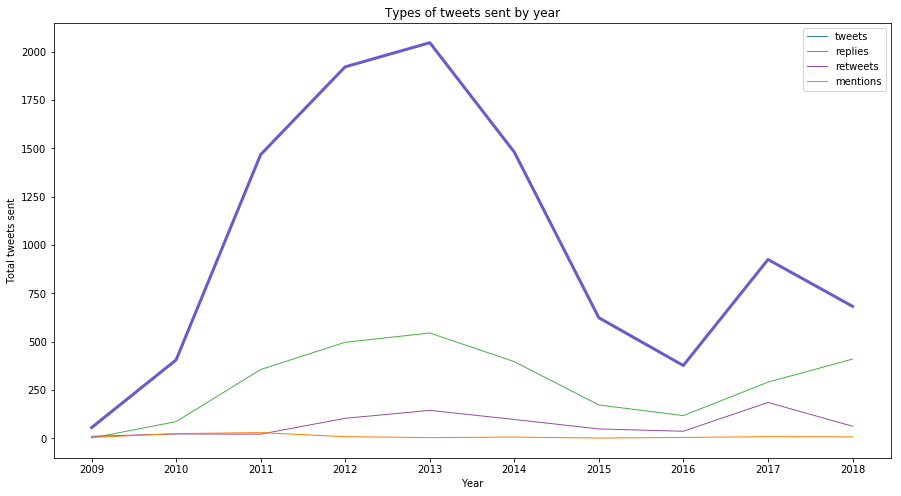

In [21]:
# plot some of the above data
# define a list of columns to plot
plot_cols = ['tweet_id', 'in_reply_to_status_id', 'retweeted_status_id', 'mention_to_user_id']

# set the figure size
plt.figure(figsize=(15,8))
 
# create a color palette
palette = plt.get_cmap('Set1')

# multiple line plot
num=0
for column in df_time[plot_cols]:
    num+=1
    plt.plot((df_time!=0)[column].resample('AS').sum(), marker='', color=palette(num), linewidth=1)
    
# now re do the most important curve, but with bigger line width
plt.plot((df_time!=0)['tweet_id'].resample('AS').sum(), marker='', color='slateblue', linewidth=3)

# add a legend with custom labels
mylabels = ['tweets','replies','retweets','mentions']
plt.legend(labels = mylabels)

# add labels and title
plt.xlabel('Year')
plt.ylabel('Total tweets sent')
plt.title('Types of tweets sent by year');

Looks like I tweeted a lot during 2012 and 2013 (around 2000 tweets per year).

It can also be seen that I started to reply more this year, and with more than 4 months left I could even top 2013 when I had more than 500 replies.

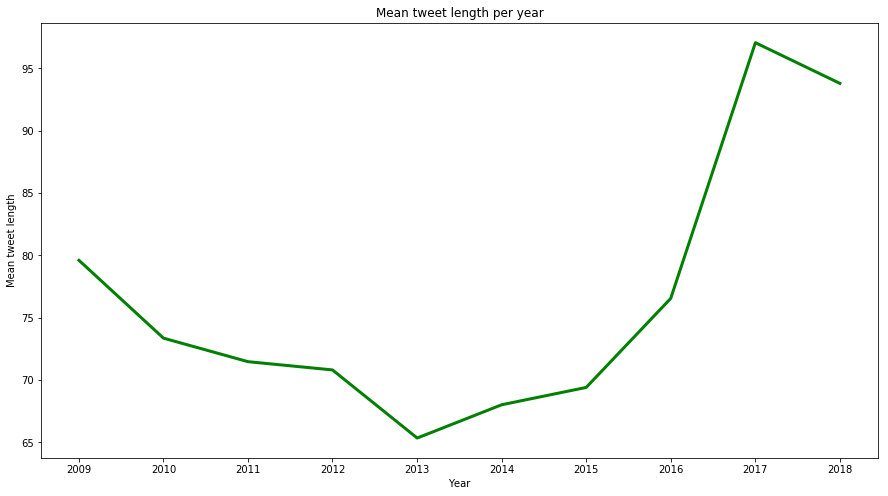

In [22]:
# set the figure size
plt.figure(figsize=(15,8))
 
# now re do the most important curve, but with bigger line width
plt.plot(df_time['tweet_length'].resample('YS').mean(), marker='', color='green', linewidth=3)

# add labels and title
plt.xlabel('Year')
plt.ylabel('Mean tweet length')
plt.title('Mean tweet length per year');

Hint: Twitter increased the maximum number of characters per tweet from 140 to 280 in November 2017, which clearly had an impact on my average tweet length.

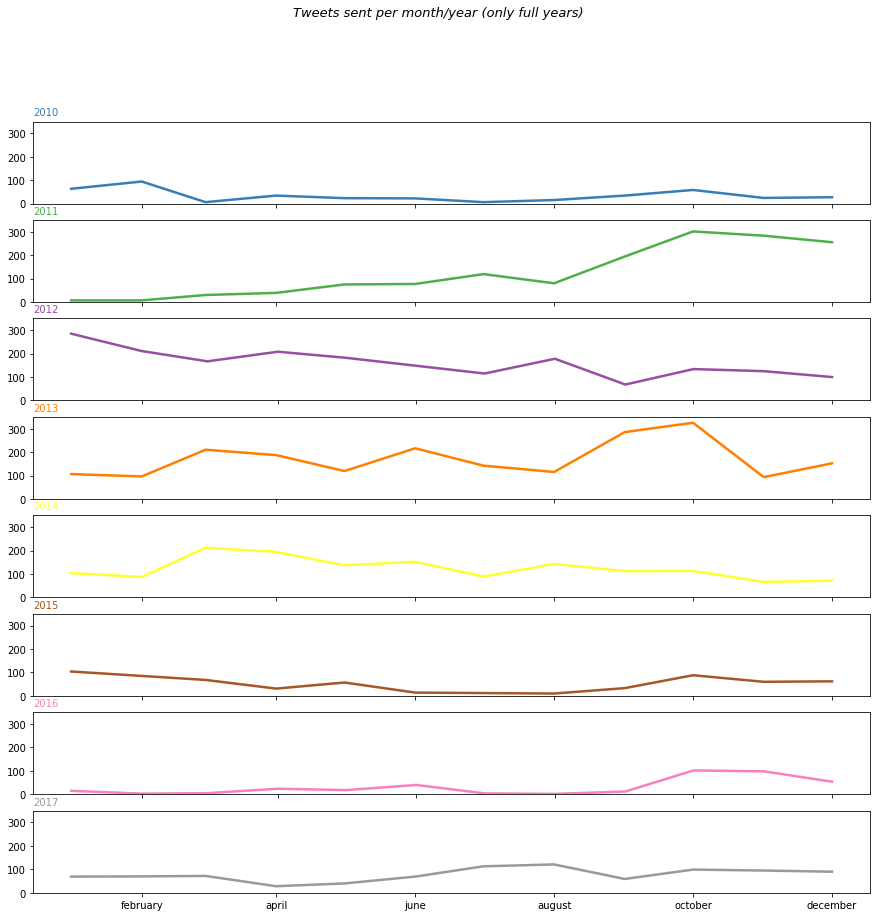

In [23]:
# plot on a yearly basis
# define a list of years as strings
years = [str(x) for x in range(2010,2018)]

# set the figure size
plt.figure(figsize=(15,16))
 
# create a color palette
palette = plt.get_cmap('Set1')

# multiple line plot of the monthly number of tweets
num=0
for year in years:
    num+=1
 
    # find the right spot on the plot
    plt.subplot(9,1, num)
    
    # plot every year
    plt.plot((df_time!=0)[year]['tweet_id'].resample('MS').count(), marker='', color=palette(num), linewidth=2.5)
    
    # same limits for every subplot
    plt.ylim(0,350)
    
    # get current position of the ticks
    locs, labels = plt.xticks()

    # add ticks with custom labels
    mylabels = ['february','april', 'june', 'august', 'october', 'december']
    plt.xticks(locs, mylabels)

    # not ticks everywhere
    if num in range(8) :
        plt.tick_params(labelbottom=False)
        
    # add title
    plt.title(year, loc='left', fontsize=10, fontweight=0, color=palette(num))
    
# add general title
plt.suptitle("Tweets sent per month/year (only full years)", fontsize=13, fontweight=0, color='black', style='italic');

If anything, it seems that october is a month were I tend to start tweeting more often.

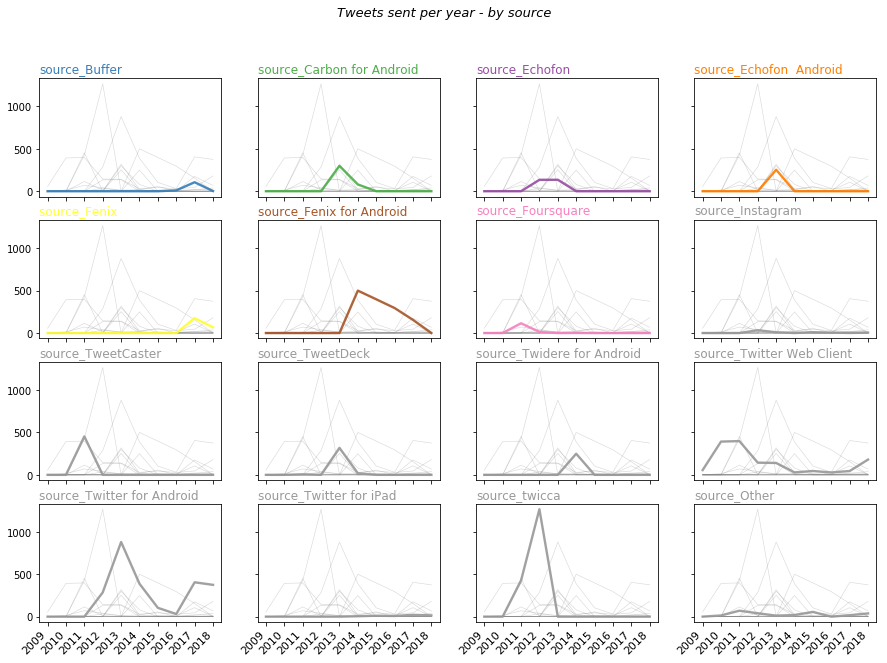

In [24]:
# get list of all source columns
# need to create a new list since the old one has been outdated with the lesser source columns merge
source_cols = list(df_time.columns[df_time.columns.str.startswith('source')])

# set the figure size
plt.figure(figsize=(15,10))

# multiple line plot of the yearly number of tweets per source
num=0
for column in df_time[source_cols]:
    num+=1
 
    # find the right spot on the plot
    plt.subplot(4,4, num)
    
    # plot every column, but discreet
    for v in df_time[source_cols]:
        plt.plot((df_time!=0)[v].resample('AS').sum(), marker='', color='grey', linewidth=0.6, alpha=0.3)
 
    # plot the lineplot
    plt.plot((df_time!=0)[column].resample('AS').sum(), marker='', color=palette(num), linewidth=2.4, alpha=0.9, label=column)
 
    # not ticks everywhere
    if num in range(13) :
        plt.tick_params(labelbottom=False)
    if num not in [1,5,9,13] :
        plt.tick_params(labelleft=False)
    
    # rotate the ticks
    plt.xticks(rotation=45, fontsize='11', horizontalalignment='right')
        
    # add title
    plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num))

# add general title
plt.suptitle("Tweets sent per year - by source", fontsize=13, fontweight=0, color='black', style='italic');

Now, this is an insightful visualization! One could talk for hours just by looking at those plots.

For me the most interesting take-away here is how much I loved twicca back in the day. I tried a lot of other clients afterwards but nothing came ever close to twicca.

# bonus: weekdays, month days, hours

In [25]:
# create new columns based on timestamp
df['weekdaynum'] = df['timestamp'].dt.dayofweek
df['weekday'] = df['timestamp'].dt.weekday_name
df['monthdaynum'] = df['timestamp'].dt.day
df['hourofday'] = df['timestamp'].dt.hour

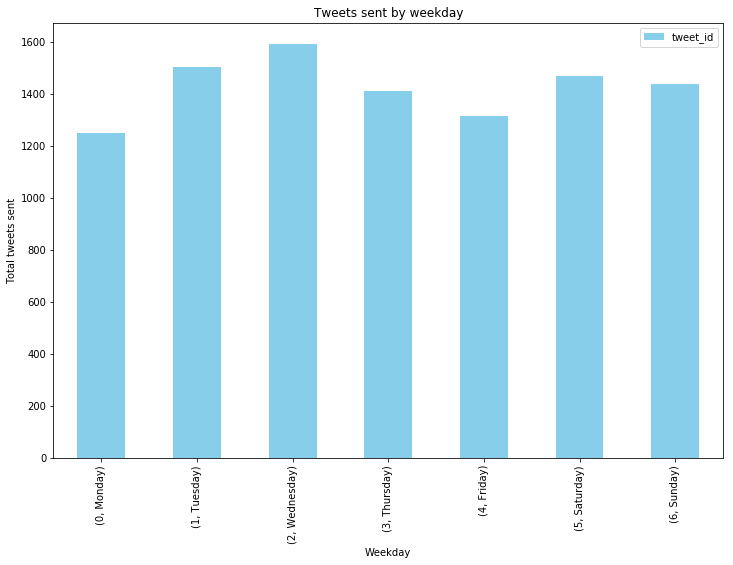

In [26]:
# create a bar plot with weekdays
df.pivot_table(index=['weekdaynum','weekday'],values='tweet_id',aggfunc='count').plot(kind='bar',figsize=(12,8),color='skyblue')

# set the labels and title
plt.ylabel('Total tweets sent')
plt.xlabel('Weekday')
plt.title('Tweets sent by weekday');

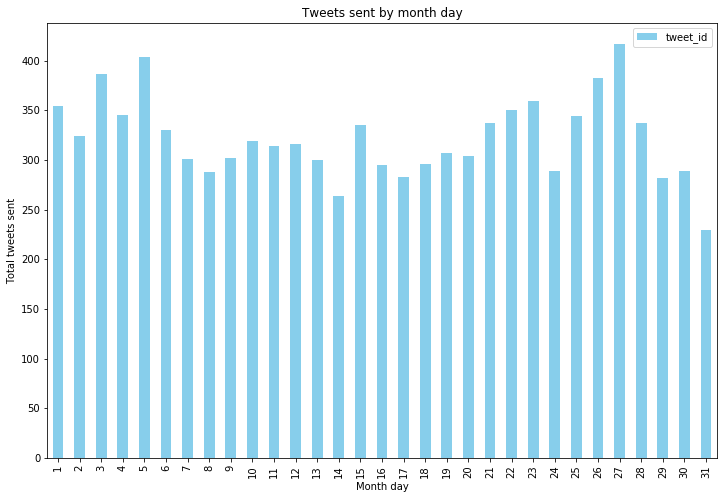

In [27]:
# create a bar plot with month days
df.pivot_table(index='monthdaynum',values='tweet_id',aggfunc='count').plot(kind='bar',figsize=(12,8),color='skyblue')

# set the labels and title
plt.ylabel('Total tweets sent')
plt.xlabel('Month day')
plt.title('Tweets sent by month day');

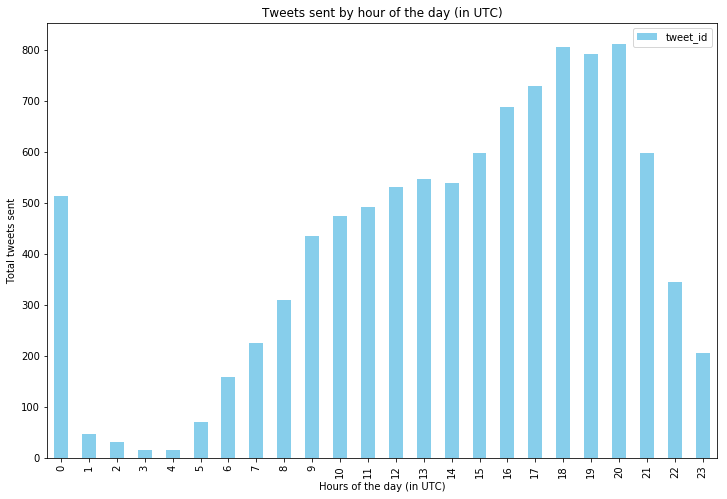

In [28]:
# create a bar plot with hours of day
df.pivot_table(index='hourofday',values='tweet_id',aggfunc='count').plot(kind='bar',figsize=(12,8),color='skyblue')

# set the labels and title
plt.ylabel('Total tweets sent')
plt.xlabel('Hours of the day (in UTC)')
plt.title('Tweets sent by hour of the day (in UTC)');

References:

- [Python Graph Gallery](https://python-graph-gallery.com)
- [Turn Your Twitter Timeline into a Word Cloud by Sebastian Raschka](https://sebastianraschka.com/Articles/2014_twitter_wordcloud.html)
- [Sentiment Analysis article on dev.to](https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-)
- [Data Exploration notebook on Kaggle](https://www.kaggle.com/dotman/data-exploration-and-visualization/notebook)